# Imports

In [1]:
# standard libraries
import pandas as pd
import numpy as np

# visualization library
import altair as alt

# modeling libaries
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# enable altair visualizations
alt.renderers.enable()

# opaque background
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

# Load Data Functions

In [3]:
# function to reduce size of dataframes
def downcast_df(file):
    df = pd.read_csv(file)
    
    # isolate data types
    df_int = df.select_dtypes(include=['int64'])
    df_float = df.select_dtypes(include=['float64'])
    df_obj = df.select_dtypes(include=['object'])
    
    # downcast ints and floats
    df_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df_float = df_float.apply(pd.to_numeric, downcast='float')
    
    # recombine into single dataframe
    optimized_df = df.copy()
    optimized_df[df_int.columns] = df_int
    optimized_df[df_float.columns] = df_float
    
    # return statement    
    return optimized_df

In [4]:
# function to print out df.info() and df.head() cleanly
def print_info(df):
    print(("=" * 10) + " Info " + ("=" * 10) + "\n")
    print(df.info())
    print("\n" + ("=" * 10) + " First 5 Rows " + ("=" * 10) + "\n")
    print(df.head())

# DataFrames

Loading all datasets, along with info (row data, memory usage), and first 5 rows of data. 

In [5]:
products = downcast_df('products.csv')

In [6]:
# product dictionaries for future usage in mapping
product_dict = dict(zip(products['product_name'], products['product_id']))
product_dict_inv = dict([v,k] for k,v in product_dict.items())

In [7]:
orders = downcast_df('orders.csv')
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(-99)
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('int16')

In [8]:
aisles = downcast_df('aisles.csv')

In [9]:
departments = downcast_df('departments.csv')

In [10]:
prior = downcast_df('order_products__prior.csv')

In [11]:
train = downcast_df('order_products__train_cap.csv')

In [12]:
test = downcast_df('order_products__test_cap.csv')

# Merge Prior, Order, and Product DataFrames

In [14]:
prior_merge1 = pd.merge(prior, products, on="product_id", how="left")
df = pd.merge(prior_merge1, orders, on="order_id", how="left")
df = df.drop(['eval_set'], axis=1)
df['days_since_prior_order'] = df['days_since_prior_order'].fillna(-1).astype('int16')
product_count = df.groupby('product_id').size()
df['count'] = df['product_id'].map(product_count).astype('uint32')

In [15]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,count
0,2,33120,1,1,Organic Egg Whites,86,16,202279,3,5,9,8,19400
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,3,5,9,8,67449
2,2,9327,3,0,Garlic Powder,104,13,202279,3,5,9,8,6299
3,2,45918,4,1,Coconut Butter,19,13,202279,3,5,9,8,744
4,2,30035,5,0,Natural Sweetener,17,13,202279,3,5,9,8,569


In [16]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 13 columns):
order_id                  uint32
product_id                uint16
add_to_cart_order         uint8
reordered                 uint8
product_name              object
aisle_id                  uint8
department_id             uint8
user_id                   uint32
order_number              uint8
order_dow                 uint8
order_hour_of_day         uint8
days_since_prior_order    int16
count                     uint32
dtypes: int16(1), object(1), uint16(1), uint32(3), uint8(7)
memory usage: 3.4 GB


# Data Exploration

Exploration of various attributes of product and order data. 

## Time of Day

In [18]:
time_of_day = orders['order_hour_of_day'].value_counts()
time_of_day = time_of_day.reset_index()
time_of_day['pct_of_total'] = np.round((time_of_day['order_hour_of_day'] / time_of_day['order_hour_of_day'].sum()*100), 2)

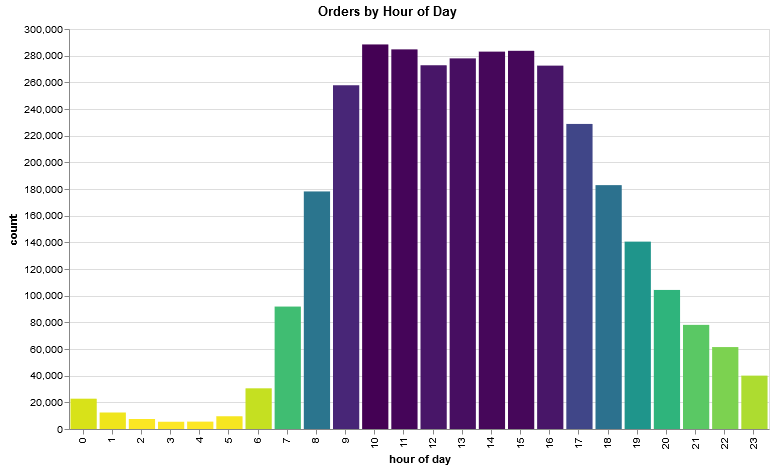

In [19]:
time_of_day_chart = alt.Chart(time_of_day).mark_bar().encode(
    alt.X("index:O", bin=False, title="hour of day"),
    alt.Y('order_hour_of_day:Q', title="count"),
    color = alt.Color('order_hour_of_day', legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip('index:O', title="Hour of Day"), alt.Tooltip('order_hour_of_day:Q'), alt.Tooltip('pct_of_total:Q')]
    ).properties(title="Orders by Hour of Day", width=700, height=400)

time_of_day_chart

From this, we can see that most orders come in the 7am - 9pm timeframe, with heaviest demand from 9am - 5pm. 

## Orders by Day of Week

In [20]:
# dictionaries and lists for day of week
dayofweek_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 0}
inv_dayofweek_dict = {v: k for k, v in dayofweek_dict.items()}
dayofweek_list = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

In [21]:
dow = orders['order_dow'].value_counts()
dow = dow.reset_index()
dow.columns = ['index', 'count']
dow['pct_of_total'] = np.round((dow['count'] / dow['count'].sum()*100), 2)
dow['day'] = dow['index'].map(inv_dayofweek_dict)

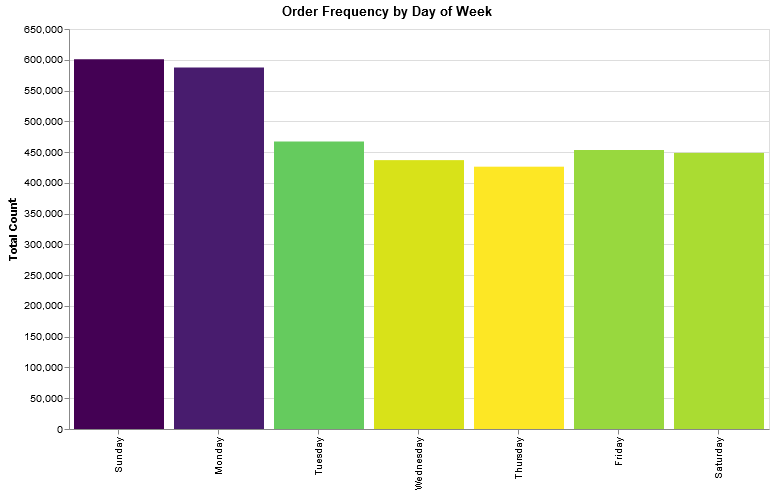

In [22]:
day_of_week_chart = alt.Chart(dow).mark_bar().encode(
    alt.X("day:O", bin=False, sort=dayofweek_list, title=""),
    alt.Y('count:Q', title="Total Count"),
    color = alt.Color('count', legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip('day:O', title="Day of Week"), alt.Tooltip('count:Q'), alt.Tooltip('pct_of_total:Q')]
    ).properties(title="Order Frequency by Day of Week", width=700, height=400)

day_of_week_chart

From this chart, we can see that orders are spread out reasonably well over the week, but Sunday and Monday are the busiest days, account for ~ 34% of all orders. Differences between Tuesday thru Saturday appear to be neglible, so we can think of the week in terms of two categories: Sunday + Monday (peak days) and Tues - Sat.   

## Days Since Last Order

In [23]:
days_since_prior = orders['days_since_prior_order'].value_counts()
days_since_prior = days_since_prior.reset_index()
days_since_prior.columns = ['days_since_prior_order', 'count']
days_since_prior = days_since_prior.sort_values(by=['days_since_prior_order'])
days_since_prior = days_since_prior.drop(6, axis=0)
days_since_prior = days_since_prior.reset_index(drop=True)
days_since_prior['pct_of_total'] = np.round((days_since_prior['count'] / days_since_prior['count'].sum()*100), 2)

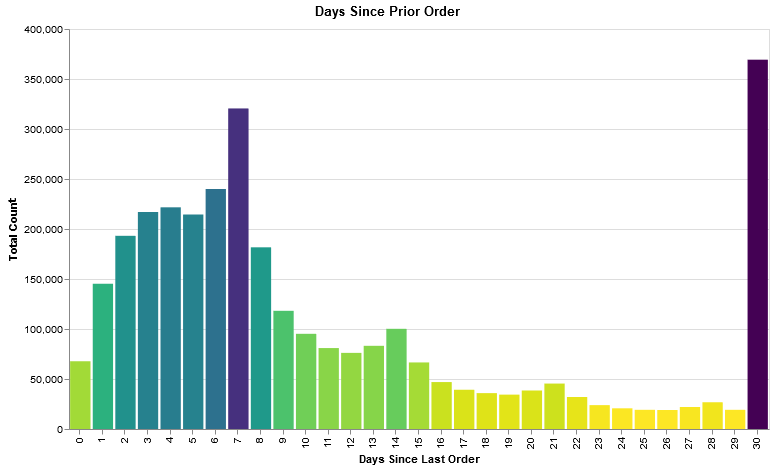

In [24]:
prev_order_chart = alt.Chart(days_since_prior).mark_bar().encode(
    alt.X("days_since_prior_order:O", bin=False, title="Days Since Last Order"),
    alt.Y('count:Q', title="Total Count"),
    color = alt.Color('count', legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip('days_since_prior_order:Q', title="Days since Last Order"), alt.Tooltip('count:Q'), alt.Tooltip('pct_of_total:Q')]
    ).properties(title="Days Since Prior Order", width=700, height=400)

prev_order_chart

The most interesting observation here is that ~ 10% of customers reorder exactly 7 days after their prior order. Approximately 50% of customers reorder within 7 days. 

## Orders by Department

In [25]:
dept_stats = df['department_id'].value_counts().reset_index()
dept_stats.columns = ['department_id', 'freq']
dept_stats = pd.merge(dept_stats, departments, on='department_id', how='left')
dept_stats['pct_orders'] = np.round((dept_stats['freq'] / dept_stats['freq'].sum()) * 100,2)

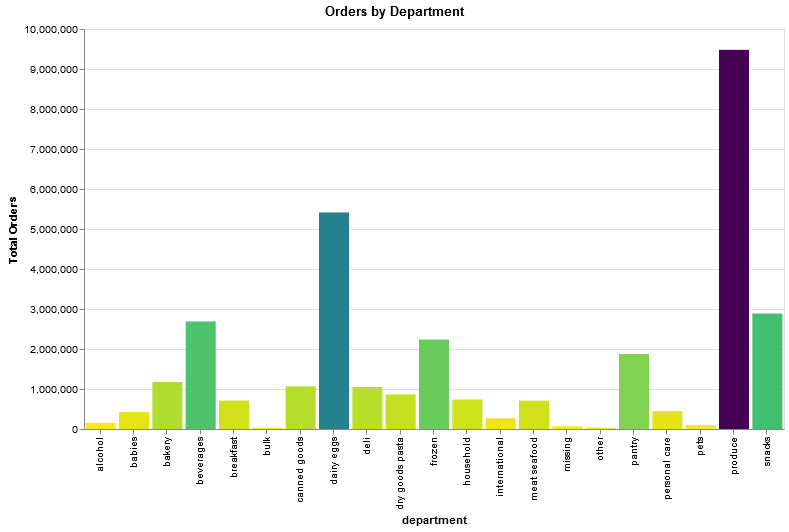

In [26]:
chart_title = "Orders by Department"
x_label = "department:O"
y_label = 'freq:Q'
pct_of_orders = 'pct_orders:Q'

dept_chart = alt.Chart(dept_stats).mark_bar().encode(
    alt.X(x_label, bin=False),
    alt.Y(y_label, title="Total Orders"),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Department"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders)]
    ).properties(title=chart_title, width=700, height=400)

dept_chart

Produce dominates this category, accounting for roughly 29% of all items purchased. Dairy + eggs are 2nd most popular department, accounting for ~ 17% of items purchased. 

## Most Popular Products

In [27]:
# 20 most commonly ordered products
df['product_name'].value_counts()[:20]

Banana                      472565
Bag of Organic Bananas      379450
Organic Strawberries        264683
Organic Baby Spinach        241921
Organic Hass Avocado        213584
Organic Avocado             176815
Large Lemon                 152657
Strawberries                142951
Limes                       140627
Organic Whole Milk          137905
Organic Raspberries         137057
Organic Yellow Onion        113426
Organic Garlic              109778
Organic Zucchini            104823
Organic Blueberries         100060
Cucumber Kirby               97315
Organic Fuji Apple           89632
Organic Lemon                87746
Apple Honeycrisp Organic     85020
Organic Grape Tomatoes       84255
Name: product_name, dtype: int64

In [28]:
# total number of orders
num_orders = orders.shape[0]

# top 30 products DF
top_prods = df['product_name'].value_counts()[:30]
top_prods = pd.DataFrame(top_prods).reset_index()
top_prods.columns = ['index', 'count']
top_prods['product_num'] = top_prods['index'].map(product_dict)
top_prods['Pct_of_Baskets'] = (top_prods['count'] / num_orders) * 100

In [29]:
top_prods.head()

,index,count,product_num,Pct_of_Baskets
0,Banana,472565,24852,13.813316
1,Bag of Organic Bananas,379450,13176,11.091517
2,Organic Strawberries,264683,21137,7.736819
3,Organic Baby Spinach,241921,21903,7.071474
4,Organic Hass Avocado,213584,47209,6.243169


In [30]:
top_prods_order_list = top_prods['index'].tolist()

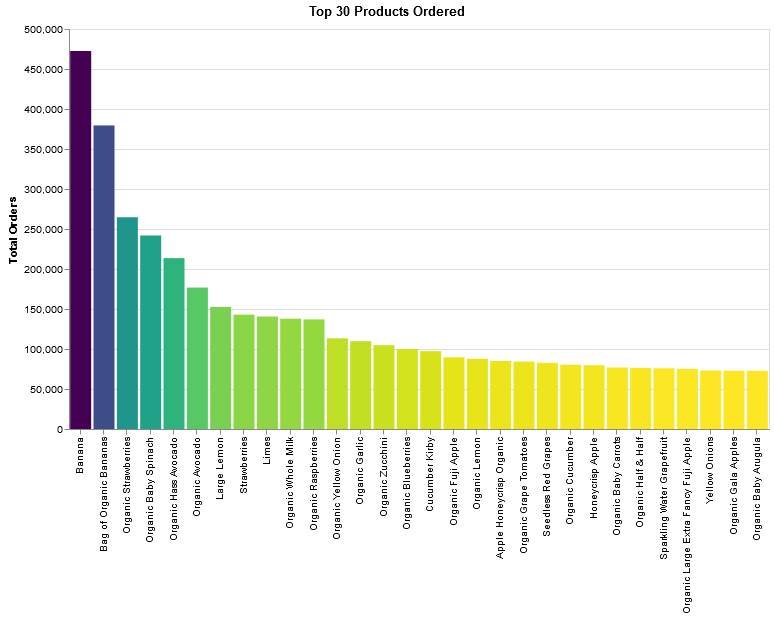

In [31]:
chart_title = "Top 30 Products Ordered"
x_label = "index:O"
y_label = 'count:Q'
pct_of_baskets = 'Pct_of_Baskets:Q'
product_num = 'product_num:O'

top_30_chart = alt.Chart(top_prods).mark_bar().encode(
    alt.X(x_label, bin=False, sort=top_prods_order_list, title=""),
    alt.Y(y_label, title="Total Orders"),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Product"), alt.Tooltip(y_label), alt.Tooltip(pct_of_baskets), alt.Tooltip(product_num)]
    ).properties(title=chart_title, width=700, height=400)

top_30_chart

Regular bananas are ordered in a whopping 13% of baskets, while organic bananas are ordered in 11%. There's a significant dropoff by the time we reach the 30th most popular item (organic baby arugla), which is in 2% of baskets. Produce items dominate the top 30 products. 

In [32]:
# create dictionary for market basket % for every product

all_prods = df['product_name'].value_counts()
all_prods = pd.DataFrame(all_prods).reset_index()
all_prods.columns = ['index', 'count']
all_prods['product_id'] = all_prods['index'].map(product_dict)
all_prods['pct_pop_orders'] = (all_prods['count'] / num_orders) * 100

pct_order_dict = pd.Series(all_prods['pct_pop_orders'].values,index=all_prods['product_id']).to_dict()

## Item Order Frequency

In [33]:
products['count'] = products['product_id'].map(product_count).fillna(0).astype('uint32')

In [34]:
bin_labels = ['0-5', '6-20', '21-50','51-100','101-500','501-2500','2500-10000', '10001-50000', '50000+']
bins = [0, 6, 21, 51, 101, 501, 2501,10001, 50001, 500000]

products['count_bin'] = pd.cut(products['count'], bins, labels=bin_labels)

In [35]:
prod_count_bins = pd.DataFrame(products['count_bin'].value_counts())
prod_count_bins = prod_count_bins.reset_index()
prod_count_bins.columns = ['bin', 'count']
prod_count_bins['pct_total'] = np.round((prod_count_bins['count'] / prod_count_bins['count'].sum()) * 100,2)
prod_count_bins

,bin,count,pct_total
0,101-500,11614,23.38
1,6-20,10473,21.08
2,21-50,8689,17.49
3,51-100,6397,12.88
4,501-2500,5997,12.07
5,0-5,4234,8.52
6,2500-10000,1781,3.59
7,10001-50000,432,0.87
8,50000+,60,0.12


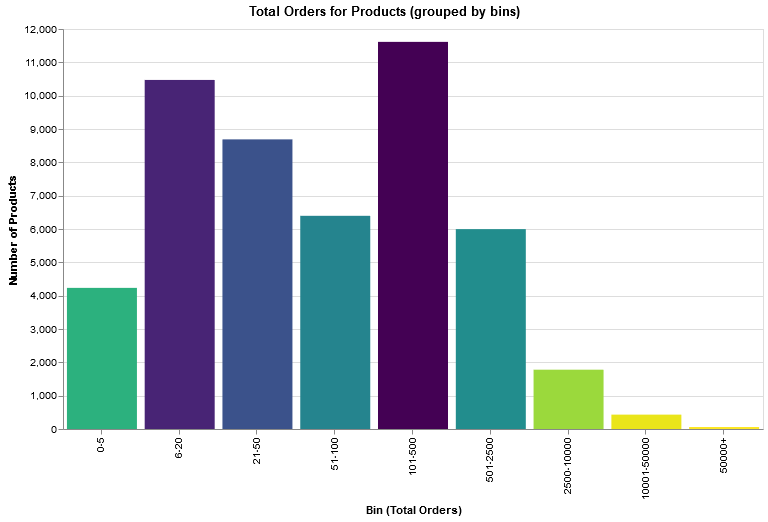

In [37]:
chart_title = "Total Orders for Products (grouped by bins)"
x_label = "bin:O"
y_label = 'count:Q'
pct_total = 'pct_total:Q'


bin_chart = alt.Chart(prod_count_bins).mark_bar().encode(
    alt.X(x_label, title="Bin (Total Orders)", sort=bin_labels),
    alt.Y(y_label, title="Number of Products"),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')), 
    tooltip=[alt.Tooltip(x_label, title="Bin"), alt.Tooltip(y_label), alt.Tooltip(pct_total)]
    ).properties(title=chart_title, width=700, height=400)

bin_chart

What this visualization tells us is that the majority of products are ordered between 0 - 100 times. Products ordered more than 10,000 times are rare (about 1% of total products) and even products ordered more than 2,500 times make up a small percentage (~ 5%) of the total number of products.

Items ordered 5 or fewer times account for 8.5% of total products and products ordered fewer than 20 times account for roughly 30% of products. A sizable percentage (~ 23%) of products are ordered between 100 and 500 times. 

# Associations

Next we'll explore associations between items. We'll look at various items purchased and what other items tend to be purchased alongside those items. 

## Items Most Frequently Ordered with Organic Strawberries

Let's start with one of the most popular items: organic strawberries. 

In [38]:
ords_org_strawberries = df[df['product_id'] == 21137]['order_id'].tolist()
# ords_org_strawberries[:10]

In [39]:
org_strawberry_df = df[df['order_id'].isin(ords_org_strawberries)]

In [40]:
# top 30 items ordered with organic strawberries
num_org_strawb = org_strawberry_df['product_name'].value_counts()[0]
top_items_org_strawb = org_strawberry_df['product_name'].value_counts()[1:31]
top_items_org_strawb

Bag of Organic Bananas                  61628
Banana                                  56156
Organic Hass Avocado                    40794
Organic Baby Spinach                    38134
Organic Raspberries                     33863
Organic Avocado                         23984
Organic Whole Milk                      23813
Organic Blueberries                     23756
Limes                                   18999
Organic Yellow Onion                    16651
Organic Cucumber                        16555
Large Lemon                             16305
Apple Honeycrisp Organic                15870
Organic Garlic                          15627
Organic Grape Tomatoes                  15573
Organic Zucchini                        15320
Organic Lemon                           15152
Organic Large Extra Fancy Fuji Apple    15113
Seedless Red Grapes                     13935
Organic Whole String Cheese             13513
Organic Gala Apples                     13298
Organic Baby Carrots              

In [41]:
top_items_org_strawb_df = pd.DataFrame(top_items_org_strawb)
top_items_org_strawb_df = top_items_org_strawb_df.reset_index()
top_items_org_strawb_df.columns = ['index', 'count']
top_items_org_strawb_df['pct_orders'] = np.round((top_items_org_strawb_df['count'] / num_org_strawb) * 100,2)
top_items_org_strawb_df['product_id'] = top_items_org_strawb_df['index'].map(product_dict)
top_items_org_strawb_df['pop_pct_orders'] = top_items_org_strawb_df['product_id'].map(pct_order_dict)
top_items_org_strawb_df['purchase_ratio'] = np.round(top_items_org_strawb_df['pct_orders'] / top_items_org_strawb_df['pop_pct_orders'], 2)
top_items_org_strawb_df.head(20)

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Bag of Organic Bananas,61628,23.28,13176,11.091517,2.10
1,Banana,56156,21.22,24852,13.813316,1.54
2,Organic Hass Avocado,40794,15.41,47209,6.243169,2.47
3,Organic Baby Spinach,38134,14.41,21903,7.071474,2.04
4,Organic Raspberries,33863,12.79,27966,4.006246,3.19
5,Organic Avocado,23984,9.06,47766,5.168393,1.75
6,Organic Whole Milk,23813,9.00,27845,4.031033,2.23
7,Organic Blueberries,23756,8.98,39275,2.924805,3.07
8,Limes,18999,7.18,26209,4.110599,1.75
9,Organic Yellow Onion,16651,6.29,22935,3.315500,1.90


In [42]:
org_straw_order_list = top_items_org_strawb_df['index'].tolist()

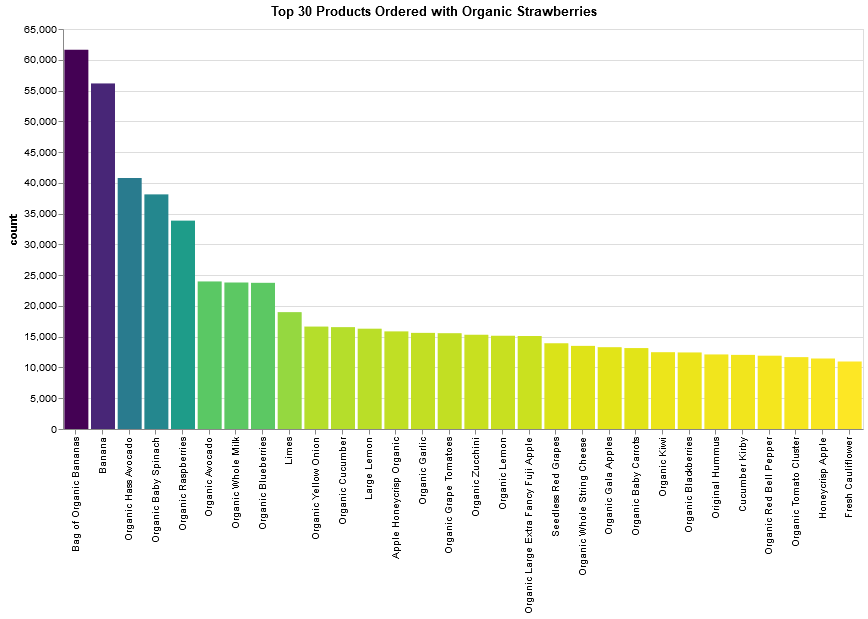

In [44]:
chart_title = "Top 30 Products Ordered with Organic Strawberries"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_id:O'
multiple = 'purchase_ratio:Q'

strawberry_chart = alt.Chart(top_items_org_strawb_df).mark_bar().encode(
    alt.X(x_label, bin=False, sort=org_straw_order_list, title=""),
    alt.Y(y_label),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Item"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders), alt.Tooltip(product_num), alt.Tooltip(multiple, title="purchase ratio")]
    ).properties(title=chart_title, width=800, height=400)

strawberry_chart

In [170]:
strawberry_chart.save('strawberry.html')

## Items Most Frequently Ordered with Honeycrisp Apples

In [45]:
# find top n items ordered with any particular product by product_id
def top_n_items(df, product_id, n):
    orders = df[df['product_id'] == product_id]['order_id'].tolist()
    orders_with_item = df[df['order_id'].isin(orders)]

    # top 30 items ordered with organic strawberries
    num_of_main_item = orders_with_item['product_name'].value_counts()[0]
    top_items_with_item = orders_with_item['product_name'].value_counts()[1:n+1]

    top_items_with_item = pd.DataFrame(top_items_with_item)
    top_items_with_item = top_items_with_item.reset_index()
    top_items_with_item.columns = ['index', 'count']
    top_items_with_item['pct_orders'] = np.round((top_items_with_item['count'] / num_of_main_item) * 100, 2)
    top_items_with_item['product_id'] = top_items_with_item['index'].map(product_dict)

    top_items_order_list = top_items_with_item['index'].tolist()
    
    return top_items_with_item

In [46]:
# top 10 items ordered with honeycrisp apples
honeycrisp_df = top_n_items(df, 45066, 20)
honeycrisp_df['pop_pct_orders'] = honeycrisp_df['product_id'].map(pct_order_dict)
honeycrisp_df['purchase_ratio'] = np.round(honeycrisp_df['pct_orders'] / honeycrisp_df['pop_pct_orders'], 2)
honeycrisp_df

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Banana,28408,35.61,24852,13.813316,2.58
1,Organic Strawberries,11465,14.37,21137,7.736819,1.86
2,Bag of Organic Bananas,11137,13.96,13176,11.091517,1.26
3,Organic Avocado,11046,13.85,47766,5.168393,2.68
4,Organic Baby Spinach,10170,12.75,21903,7.071474,1.80
5,Large Lemon,9485,11.89,47626,4.462242,2.66
6,Organic Hass Avocado,8100,10.15,47209,6.243169,1.63
7,Strawberries,7536,9.45,16797,4.178531,2.26
8,Limes,6993,8.77,26209,4.110599,2.13
9,Cucumber Kirby,6518,8.17,49683,2.844567,2.87


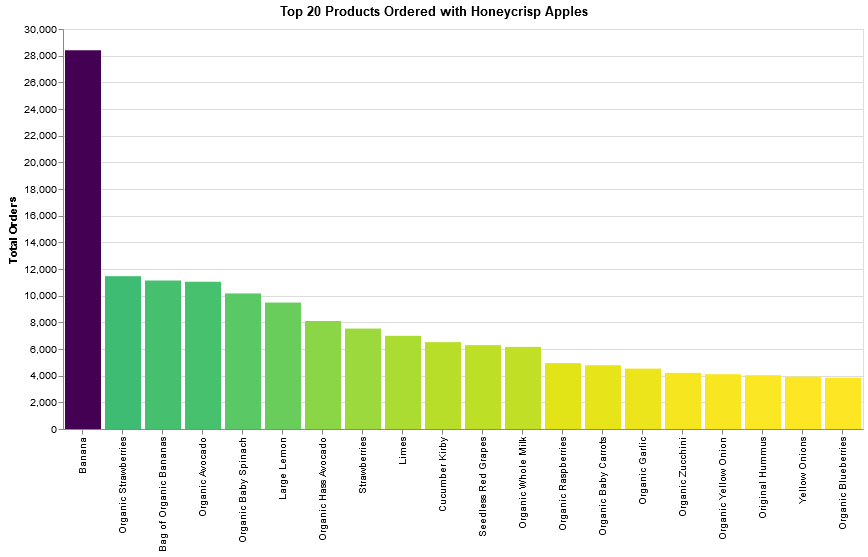

In [47]:
chart_title = "Top 20 Products Ordered with Honeycrisp Apples"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_id:O'
multiple = 'purchase_ratio:Q'
sort_list = honeycrisp_df['index'].tolist()


honeycrisp_chart = alt.Chart(honeycrisp_df).mark_bar().encode(
    alt.X(x_label, bin=False, sort=sort_list, title=""),
    alt.Y(y_label, title="Total Orders"),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Item"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders), alt.Tooltip(product_num), alt.Tooltip(multiple, title="purchase ratio")]
    ).properties(title=chart_title, width=800, height=400)

honeycrisp_chart

In [171]:
honeycrisp_chart.save('honeycrisp.html')

## Items Most Frequently Ordered with Organic Turkey Burgers

In [48]:
# top 20 items ordered with honeycrisp apples
org_turkey_burger_df = top_n_items(df, 23, 20)
org_turkey_burger_df['pop_pct_orders'] = org_turkey_burger_df['product_id'].map(pct_order_dict)
org_turkey_burger_df['purchase_ratio'] = np.round(org_turkey_burger_df['pct_orders'] / org_turkey_burger_df['pop_pct_orders'],2)
org_turkey_burger_df

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Banana,179,16.76,24852,13.813316,1.21
1,Bag of Organic Bananas,172,16.10,13176,11.091517,1.45
2,Organic Strawberries,169,15.82,21137,7.736819,2.04
3,Organic Baby Spinach,151,14.14,21903,7.071474,2.00
4,Organic Hass Avocado,135,12.64,47209,6.243169,2.02
5,Organic Avocado,114,10.67,47766,5.168393,2.06
6,Organic Raspberries,101,9.46,27966,4.006246,2.36
7,Organic Baby Carrots,99,9.27,42265,2.247709,4.12
8,Organic Zucchini,82,7.68,45007,3.064030,2.51
9,Large Lemon,75,7.02,47626,4.462242,1.57


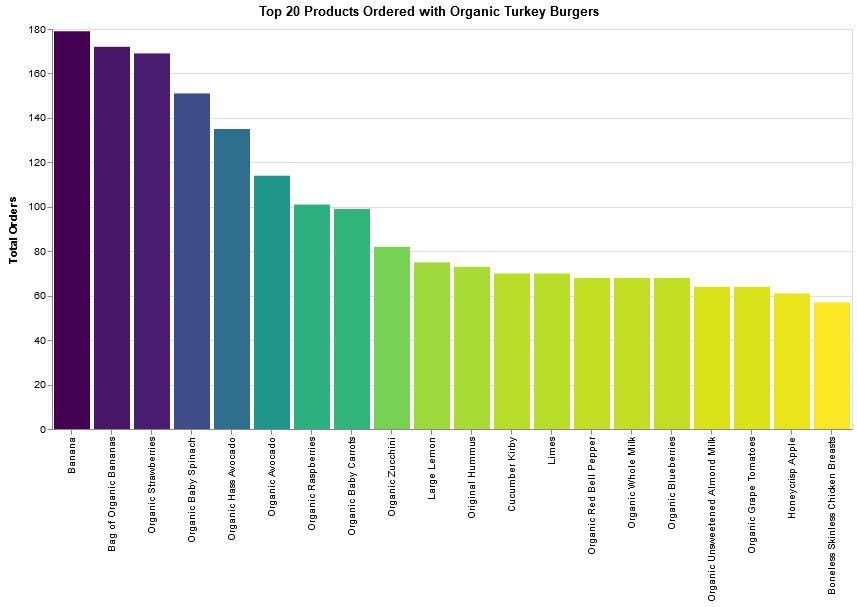

In [49]:
chart_title = "Top 20 Products Ordered with Organic Turkey Burgers"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_id:O'
multiple = 'purchase_ratio:Q'
sort_list = org_turkey_burger_df['index'].tolist()


turkey_chart = alt.Chart(org_turkey_burger_df).mark_bar().encode(
    alt.X(x_label, bin=False, sort=sort_list, title=""),
    alt.Y(y_label, title="Total Orders"),
    color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
    tooltip=[alt.Tooltip(x_label, title="Item"), alt.Tooltip(y_label), alt.Tooltip(pct_of_orders, title="% of Orders"), 
             alt.Tooltip(product_num), alt.Tooltip(multiple, title="purchase ratio")]
    ).properties(title=chart_title, width=800, height=400)

turkey_chart

In [172]:
turkey_chart.save('turkey.html')

# Recommendation Algorithm Prototypes

Now we'll look at a few simple ideas for recommendation algorithms. We'll start by using an idea we already explored: finding items that are purchased more frequently than average when a customer purchases a particular item. 

## Frequently Purchaed Items

To get started, we'll tweek our "top_n_items" function, so that it finds the top 100 items, but then sorts the items based on how much more often the item is purchased versus the average basket. For instance, if we find that customers that purchase goat cheese are 6 times more likely to purchase mozzarella than the average customer, we make that a top recommendation.

In [86]:
# find top n items ordered with any particular product by product_id
def top_n_recommendations(df, product_id, n):
    orders = df[df['product_id'] == product_id]['order_id'].tolist()
    orders_with_item = df[df['order_id'].isin(orders)]

    # top 30 items ordered with organic strawberries
    num_of_main_item = orders_with_item['product_name'].value_counts()[0]
    top_items_with_item = orders_with_item['product_name'].value_counts()[1:n+1]

    top_items_with_item = pd.DataFrame(top_items_with_item)
    top_items_with_item = top_items_with_item.reset_index()
    top_items_with_item.columns = ['index', 'count']
    top_items_with_item['pct_orders'] = np.round((top_items_with_item['count'] / num_of_main_item) * 100, 2)
    top_items_with_item['product_id'] = top_items_with_item['index'].map(product_dict)
    
    top_items_with_item['pop_pct_orders'] = top_items_with_item['product_id'].map(pct_order_dict)
    top_items_with_item['purchase_ratio'] = np.round(top_items_with_item['pct_orders'] / top_items_with_item['pop_pct_orders'],2)
    
    
    top_items_with_item = top_items_with_item.sort_values(by=['purchase_ratio'], ascending=False)
    top_items_with_item = top_items_with_item[:10]
    top_items_with_item = top_items_with_item.reset_index(drop=True)

    top_items_order_list = top_items_with_item['index'].tolist()
    
    return top_items_with_item

In [131]:
def top_n_rec_viz(df, product_id):
    
    product_name = product_dict_inv[product_id]
    chart_title = "Top 10 Recs based on purchase of " + product_name
    x_label = "index:O"
    y_label = 'purchase_ratio:Q'
    pct_of_orders = 'pct_orders:Q'
    product_num = 'product_id:O'
    multiple = 'purchase_ratio:Q'
    total_orders = 'count:Q'
    sort_list = df['index'].tolist()


    turkey_chart = alt.Chart(df).mark_bar().encode(
        alt.X(x_label, bin=False, sort=sort_list, title=""),
        alt.Y(y_label, title="Purchased X Times More then Average"),
        color = alt.Color(y_label, legend=None, sort="descending", scale=alt.Scale(scheme='viridis')),
        tooltip=[alt.Tooltip(x_label, title="Item"), alt.Tooltip(product_num, title="Product ID"), alt.Tooltip(y_label, title="Purchase Ratio"), 
                 alt.Tooltip(pct_of_orders, title="% of Orders"), alt.Tooltip(total_orders, title="Total Orders") ]
        ).properties(title=chart_title, width=800, height=400).configure_axis(
    labelFontSize=12,
    titleFontSize=12 
).configure_title(fontSize=18)

    return turkey_chart

### Organic Turkey Burgers

Let's now re-examine our organic turkey burgers. We'll find the 100 items most frequently purchased with the burgers. We'll then recommend the top 10 items (from the top 100) based on how much more likely than average the customer is to purchase that item. 

In [87]:
turkey_recs = top_n_recommendations(df, 23, 100)
turkey_recs

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Grilled Chicken Breast Strips,25,2.34,17878,0.195055,12.00
1,Naturals Chicken Nuggets,30,2.81,2452,0.305810,9.19
2,Organic Chicken Strips,29,2.72,43504,0.324751,8.38
3,Organic Baby Spinach Salad,44,4.12,25931,0.516562,7.98
4,Organic Original Hommus,30,2.81,2825,0.389935,7.21
5,Organic Turkey Bacon,34,3.18,5646,0.447285,7.11
6,Organic Thompson Seedless Raisins,27,2.53,5134,0.363335,6.96
7,Roasted Red Pepper Hummus,35,3.28,21019,0.498029,6.59
8,Organic Chicken & Apple Sausage,26,2.43,9339,0.379763,6.40
9,Organic Snipped Green Beans,33,3.09,13629,0.509283,6.07


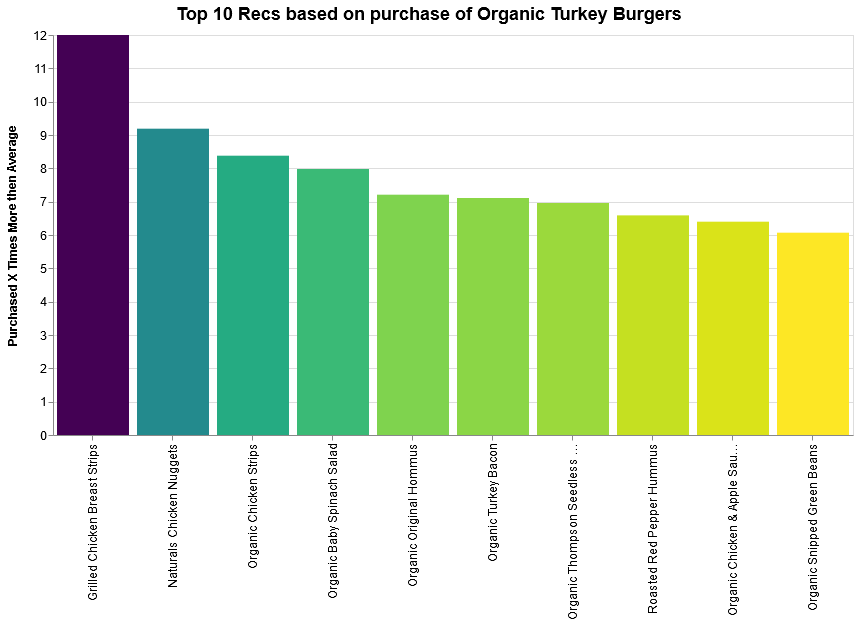

In [132]:
top_n_rec_viz(turkey_recs, 23)

In [127]:
product_dict['Blackberry Cucumber Sparkling Water']

39947

In [130]:
product_dict_inv[39947]

'Blackberry Cucumber Sparkling Water'

### Organic Shredded Mozzarella

In [128]:
mozz_recs = top_n_recommendations(df, 18370, 100)
mozz_recs

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Whole Milk Ricotta Cheese,1156,6.27,2314,0.304991,20.56
1,Pizza Sauce,509,2.76,38288,0.143405,19.25
2,Uncured Pepperoni,626,3.39,37119,0.234136,14.48
3,Organic Shredded Mild Cheddar,584,3.17,781,0.243373,13.03
4,Sliced Black Olives,507,2.75,14462,0.316157,8.70
5,Grated Parmesan,1699,9.21,33731,1.322330,6.96
6,Shredded Parmesan,1307,7.08,4799,1.062967,6.66
7,Organic Chopped Spinach,417,2.26,18918,0.348574,6.48
8,Organic Tomato Sauce,424,2.30,44449,0.397447,5.79
9,Organic Tomato Basil Pasta Sauce,494,2.68,39619,0.491774,5.45


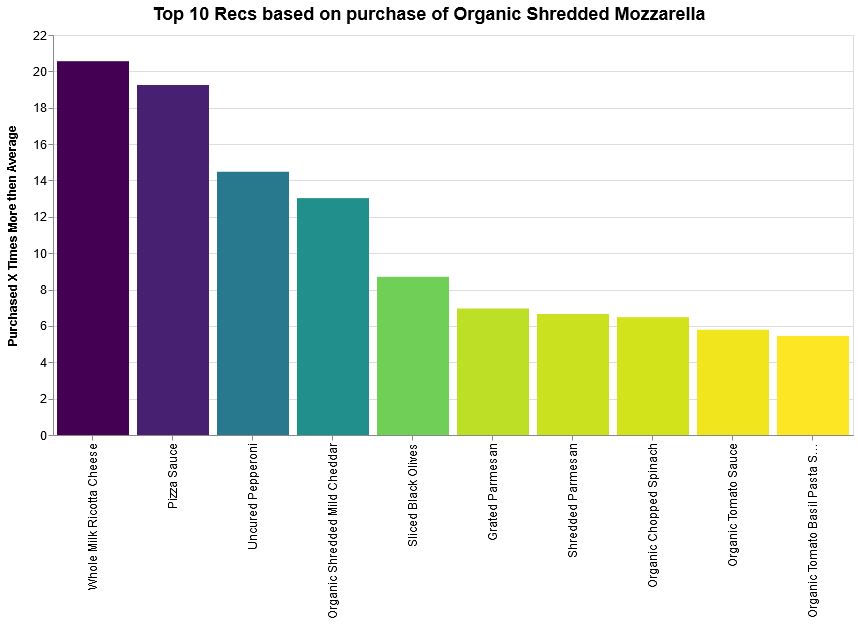

In [133]:
top_n_rec_viz(mozz_recs, 18370)

### Sourdough Bread

In [138]:
bread_recs = top_n_recommendations(df, 21267, 100)
bread_recs

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Salted Butter,419,2.57,35108,0.560144,4.59
1,Sea Salt Pita Chips,353,2.16,31040,0.485986,4.44
2,Organic Creamy Peanut Butter,326,2.00,43713,0.527318,3.79
3,Organic Sour Cream,473,2.90,42701,0.780192,3.72
4,Uncured Genoa Salami,712,4.36,27344,1.212277,3.60
5,Whipped Cream Cheese,532,3.26,42828,0.911758,3.58
6,Sharp Cheddar Cheese,511,3.13,16185,0.881884,3.55
7,Organic Reduced Fat Milk,592,3.63,38689,1.042448,3.48
8,Unsalted Butter,561,3.44,42736,1.042565,3.30
9,Shredded Parmesan,558,3.42,4799,1.062967,3.22


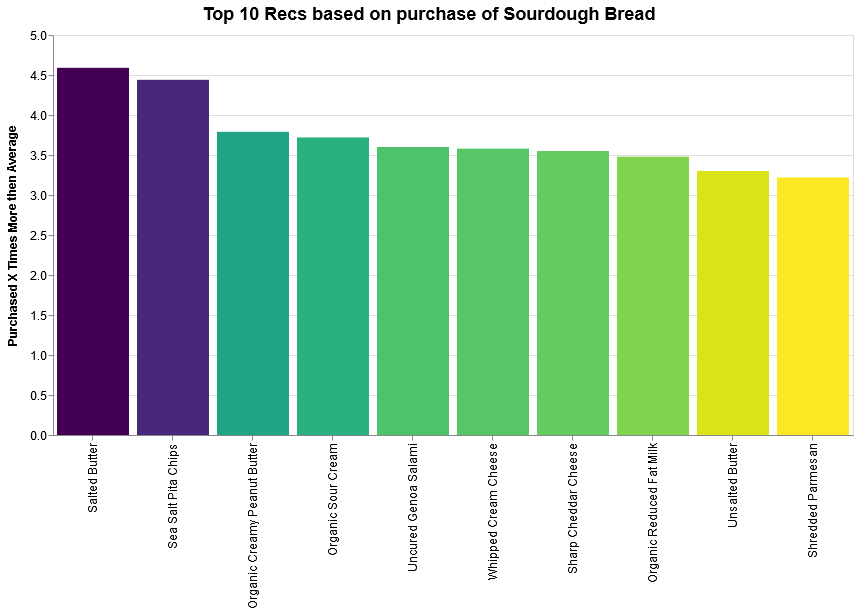

In [139]:
top_n_rec_viz(bread_recs, 21267)

### Lemon Hummus

In [136]:
hummus_recs = top_n_recommendations(df, 13646, 100)
hummus_recs

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Jalapeno Hummus,443,2.69,17429,0.225280,11.94
1,Garlic Hummus,368,2.24,7485,0.239076,9.37
2,Sea Salt Pita Chips,733,4.46,31040,0.485986,9.18
3,Feta Cheese Crumbles,624,3.80,40604,0.945636,4.02
4,Organic Peeled Whole Baby Carrots,1032,6.28,43961,1.618523,3.88
5,Organic Baby Carrots,1340,8.15,42265,2.247709,3.63
6,Organic Baby Rainbow Carrots,331,2.01,32864,0.574058,3.50
7,Organic Whole String Cheese,992,6.03,22035,1.744360,3.46
8,Original Hummus,1174,7.14,30489,2.084545,3.43
9,Whipped Cream Cheese,507,3.08,42828,0.911758,3.38


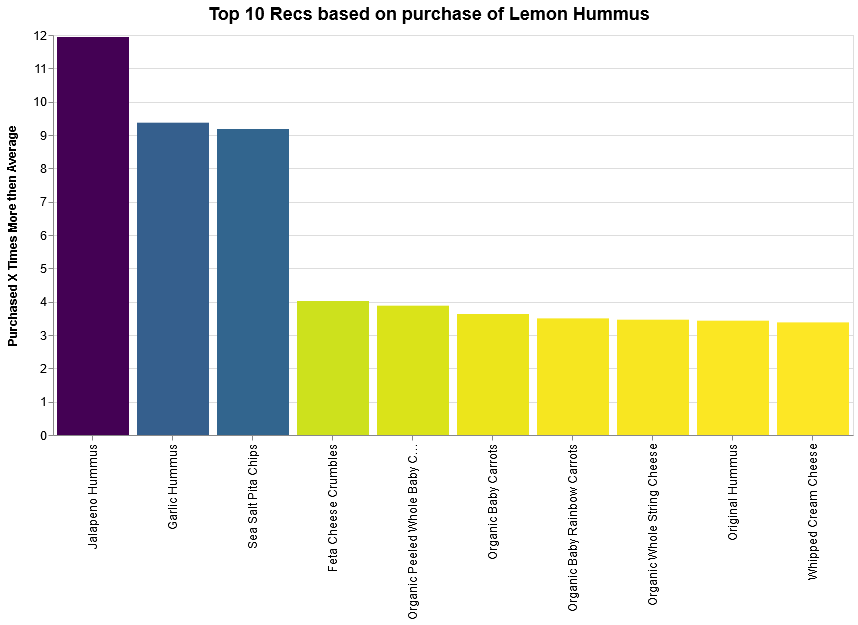

In [137]:
top_n_rec_viz(hummus_recs, 13646)

### Blackberry Cucumber Sparkling Water

In [134]:
bcwater_recs = top_n_recommendations(df, 39947, 100)
bcwater_recs

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Kiwi Sandia Sparkling Water,3160,28.12,12576,0.267401,105.16
1,Curate Melon Pomelo Sparking Water,2389,21.26,45747,0.206075,103.17
2,Pineapple Strawberry Sparkling Water,651,5.79,27275,0.072258,80.13
3,Pineapple Strawberry Naturally Essenced Sparkl...,267,2.38,28342,0.031277,76.10
4,Curate Pomme Baya-Apple Berry Sparkling Water,678,6.03,41682,0.080735,74.69
5,Curate Cherry Lime Sparkling Water,1428,12.71,30353,0.262315,48.45
6,Peach-Pear Sparkling Water,329,2.93,1831,0.084125,34.83
7,Passionfruit Sparkling Water,858,7.64,31964,0.219755,34.77
8,Cran-Raspberry Flavored Sparkling Water,304,2.71,7693,0.112187,24.16
9,Coconut Sparkling Water,263,2.34,12919,0.120254,19.46


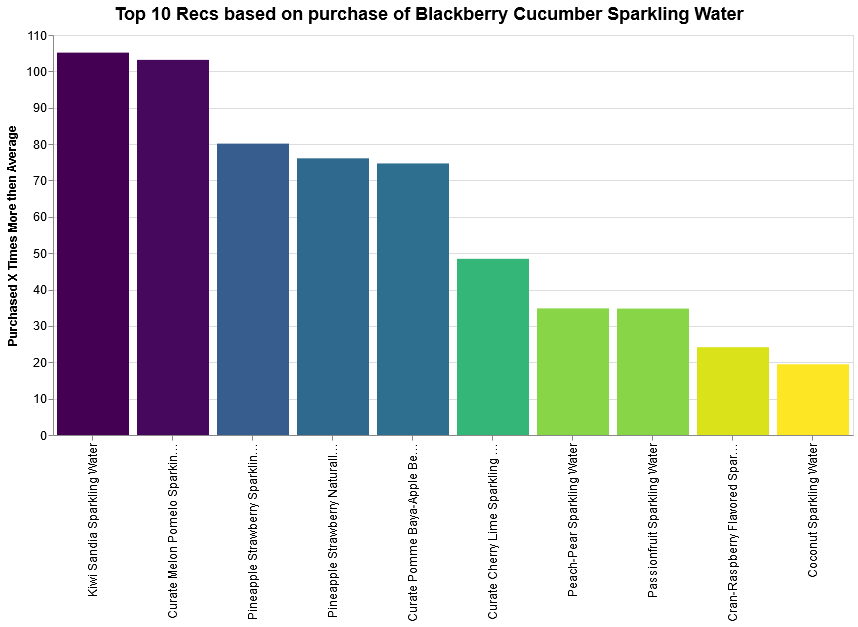

In [135]:
top_n_rec_viz(bcwater_recs, 39947)

## Similar Products (Cosine Similarity)

The next type of algorithm will look also examines item similiarity, but this time we'll use cosine similiarity between all of our items to find the best matches. This is more computationally intensive than our last methodology. I've shrunk the training dataset in order to run this in Pandas, but for a full-scale version, we'd likely run it using a big data platform such as Spark or Dask. 

In [86]:
train.shape

(1038515, 4)

In [141]:
# smaller training dataframe
train_sm = train[:100000].copy()
train_sm.head()

,order_id,product_id,add_to_cart_order,reordered
0,36,39612,1,0
1,36,19660,2,1
2,36,49235,3,0
3,36,43086,4,1
4,36,46620,5,1


In [19]:
train_sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
order_id             100000 non-null uint32
product_id           100000 non-null uint16
add_to_cart_order    100000 non-null uint8
reordered            100000 non-null uint8
dtypes: uint16(1), uint32(1), uint8(2)
memory usage: 781.3 KB


In [142]:
# create sparse matrix of products and orders
productPivot = train_sm.pivot(index='product_id', columns='order_id', values='reordered')

In [143]:
# fill in all nulls with 0 and all non-null values with 1
productPivot[productPivot.notnull()] = 1
productPivot[productPivot.isnull()] = 0

In [144]:
productPivot.shape

(16635, 9402)

In [145]:
# create our cosine similiartiy matrix
product_sim_matrix = cosine_similarity(productPivot)

In [146]:
# function to find n similar items
def find_similar_items(prod_id, matrix, n):
    
    index_num = np.where(productPivot.index == prod_id)[0][0]
    
    match_list = []
    score_list = []
    
    matrix = matrix[index_num]
    
    for i in range(len(matrix)):
        if matrix[i] > 0.05 and matrix[i] < 0.99:
            match_list.append(i)
            score_list.append(matrix[i])
            
    order_match_list = productPivot[productPivot.reset_index().index.isin(match_list)].index.values.tolist()
      
    df = products[products['product_id'].isin(order_match_list)].copy()
    df['sim_score'] = score_list
    df = df.sort_values(by=['sim_score'], ascending=False)
    df = df[:n]
    
    return df

### Chocolate Sandwich Cookies

Let's first test this out on the first item in our product table: "Chocalate Sandwich Cookies"

In [85]:
# similarity to chocolate sandwich cookies
find_similar_items(1, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,sim_score
24069,24070,Spicy Homestyle Guacamole,1,20,0.333333
29872,29873,Morena Pure Cane Sugar,17,13,0.333333
39812,39813,Rice Sea Salt & Pepper Snacks,78,19,0.333333
10961,10962,Extra Strength Energy Shot,64,7,0.333333
11303,11304,Ground Black Silk Dark Coffee,26,7,0.333333
13819,13820,Peanut Butter Cookies,8,3,0.333333
16304,16305,Ritz Crackers,78,19,0.333333
33739,33740,"Cara Cara Oranges, Bag",24,4,0.333333
33637,33638,Mint Rolls,46,19,0.333333
43961,43962,Coleslaw,123,4,0.235702


The algorithm seems to provide reasonable results, recommending items such as peanut butter cookies, Ritz crackers, and rice sea salt & pepper snacks. However, some results seem odd, such as coleslaw and cara cara oranges. It the algorithm uncovering a deeper connection or is it simply giving us random noise?

### Organic Turkey Burgers

Next, let's take another look at our organic turkey burgers

In [90]:
# organic turkey burgers
find_similar_items(23, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,sim_score
32332,32333,Apple + Banana Fruit Bar,3,19,0.577350
24582,24583,Organic Unsweetened & Salt Free Sunflower See...,88,13,0.577350
43634,43635,Whole Milk Greek Plain,120,16,0.408248
35126,35127,Matcha Almondmilk,31,7,0.333333
46324,46325,Original Sparkling Water,115,7,0.333333
29573,29574,Tempt Unsweetened Vanilla Hemp Milk,91,16,0.288675
25019,25020,Organic Banana Chips,50,19,0.288675
275,276,French Vanilla Ice Cream,37,1,0.258199
20167,20168,Organic Sunflower Seed Spread,88,13,0.235702
22720,22721,Creamy Peanut Butter Dark Roasted,88,13,0.218218


This algorithm provides much different recommendations. Items it suggests purchasing include whole milk greek yogurt (plain), original sparkling water, and sunflower seed oil. My initial view of this is skepticism; however, the algorithm may perform better using the full training dataset, as sparse matrices need a very large volume of data to be workable. 

### Organic Shredded Mozzarella

In [147]:
# Organic Shredded Mozzarella
find_similar_items(18370, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,count,count_bin,sim_score
31885,31886,Pretzel In Milk Chocolate Bar,45,19,1838,501-2500,0.179605
46349,46350,Happy Baby Super Salmon Hearty Meals,92,18,180,101-500,0.179605
47135,47136,Organic Blueberry Blast Z Fruit + Veggie Rope,3,19,335,101-500,0.179605
46954,46955,Organic Mountain Berry Spinach,50,19,588,501-2500,0.179605
10435,10436,"Granola, Original Honey",57,14,273,101-500,0.179605
35520,35521,Mountain Spring Long Lasting Deodorant for Men,80,11,155,101-500,0.179605
10468,10469,Brown Rice Pasta Shells,131,9,741,501-2500,0.179605
30504,30505,Gluten Free Class French Dinner Rolls,58,1,793,501-2500,0.179605
35902,35903,Gluten Free Garden Margherita Pizza,79,1,292,101-500,0.179605
45093,45094,Gluten Free Mild Whole Green Chiles,30,6,551,501-2500,0.179605


Similar to the cookies, the recommendations for mozzarella sometimes seem reasonable and sometimes seem off-the-wall. Margherita pizza might be a good recommendation here, but "Mountain Spring Long Lasting Deodorant for Men" seems like a bit of a stretch. Even if men are more likely to purchase mozzarella than women, men's deodorant does not pass "the common sense" test on good recommendations for customers buying mozzarella. 

### Sourdough Bread

In [148]:
find_similar_items(21267, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,count,count_bin,sim_score
38475,38476,Black Bean Chipotle Veggie Burger Patties,42,1,333,101-500,0.137361
49498,49499,Asparagus & Gruyere Ravioli,12,9,298,101-500,0.137361
8272,8273,Mighty Bar Beef with Cranberry & Sunflower See...,3,19,8,6-20,0.137361
8573,8574,Squash & Sweet Peas Stage 2,92,18,2436,501-2500,0.137361
8980,8981,No. 01 Organic Vegan Cold Pressed Juice Kale S...,31,7,101,51-100,0.137361
42051,42052,Lavender Hand Sanitizer,109,11,347,101-500,0.137361
9455,9456,Whole Milk Peach Yogurt Smoothies,100,21,54,51-100,0.137361
45661,45662,High Heat Cooking Grapeseed Oil,19,13,406,101-500,0.137361
30203,30204,Coconut Spray Oil,19,13,494,101-500,0.137361
30199,30200,Aspen Flower Essence Anxiety Homeopathic Remedy,6,2,9,6-20,0.137361


### Lemon Hummus

In [149]:
find_similar_items(13646, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,count,count_bin,sim_score
17420,17421,Coconut Mango Chia Vitality Beverage,31,7,416,101-500,0.164399
23507,23508,13 Gallon Recycled Trash Bags,60,17,213,101-500,0.164399
31769,31770,Organic Tofu,14,20,473,101-500,0.164399
32137,32138,Dark Roast Cold Brew Coffee Concentrate,26,7,230,101-500,0.164399
32303,32304,Reduced Sodium Vegetable Lentil & Roasted Red ...,69,15,486,101-500,0.164399
17434,17435,Original California Style Hot Sauce,5,13,328,101-500,0.164399
30034,30035,Natural Sweetener,17,13,569,501-2500,0.164399
32700,32701,Roasted Seaweed Snacks Wasabi,50,19,763,501-2500,0.164399
34941,34942,Kahuna Crunch Trail Mix,125,19,1026,501-2500,0.164399
29006,29007,Crystallized Ginger Slices,117,19,386,101-500,0.164399


### Blackberry Cucumber Sparkling Water

In [150]:
find_similar_items(39947, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,count,count_bin,sim_score
45746,45747,Curate Melon Pomelo Sparking Water,115,7,7050,2500-10000,0.230089
12575,12576,Kiwi Sandia Sparkling Water,115,7,9148,2500-10000,0.179124
31302,31303,Asparagus & Meyer Lemon Ravioli In Lemon Parsl...,12,9,43,21-50,0.171499
26669,26670,Mighty Dry Hard Cider,27,5,125,101-500,0.171499
17420,17421,Coconut Mango Chia Vitality Beverage,31,7,416,101-500,0.171499
29882,29883,Kids! Chewables Probiotic Tablets Natural Burs...,70,11,107,101-500,0.171499
28620,28621,Oatmeal Raisin Flax Soft-Baked Cookies,61,19,148,101-500,0.171499
28226,28227,Zero calorie Sport Drink,64,7,142,101-500,0.171499
28031,28032,Platinum Fresh Scent Action Pacs Dishwasher De...,100,21,8,6-20,0.171499
11159,11160,Cat Food Purrfect Delights Chicken Dulgence En...,41,8,62,51-100,0.171499


The sparkling water recommendations seem more reasonable than some of the others. Here we find that customers purchasing blackberry cucumber sparkling water would be recommended items like "Curate Melon Pomelo Sparkling Water" and "Kiwi Sandia Sparkling Water." There's even some variety with "Mighty Dry Hard Cider." Nevertheless, there are once again some odd recommendations included including dishwasher detergent and cat food. Interestingly, both the detergent and cat food are not frequentliy purchased items, so perhaps the algorithm would work better with more data that might filter out obscure items such as these. 

## Similar Baskets (Cosine Similiarity)

Our final approach will be to look at cosine similiarity once again, but this time, we'll do it on an order / basket basis. Instead of analyzing product similiarity, we are thus analyzing "market basket similiarity" and recommending products that have come from similiar baskets. 

In [108]:
train_200k = train[:200000].copy()

In [109]:
orderPivot = train_200k.pivot(index='order_id', columns='product_id', values='reordered')

In [110]:
orderPivot[orderPivot.notnull()] = 1
orderPivot[orderPivot.isnull()] = 0

In [111]:
orderPivot.shape

(18874, 22376)

In [112]:
order_sim_matrix = cosine_similarity(orderPivot)

In [134]:
def find_similar_baskets(matrix):
    match_list = []

    for i in range(len(matrix)):
        if matrix[i] > 0.1 and matrix[i] < 0.99:
            match_list.append(i)
            
    order_match_list = orderPivot[orderPivot.reset_index().index.isin(match_list)].index.values.tolist()
    
    return order_match_list

In [ ]:
# def find_similar_baskets(order_id):
#     match_list = []

#     for i in range(len(matrix)):
#         if matrix[i] > 0.2 and matrix[i] < 0.99:
#             match_list.append(i)
            
#     order_match_list = orderPivot[orderPivot.reset_index().index.isin(match_list)].index.values.tolist()
    
#     return order_match_list

In [122]:
matched_baskets = find_similar_baskets(order_sim_matrix[0])

In [104]:
sample_order = train_sm[train_sm['order_id']==36].copy()
sample_order['product_name'] = sample_order['product_id'].map(product_dict_inv)
sample_order

,order_id,product_id,add_to_cart_order,reordered,product_name
0,36,39612,1,0,Grated Pecorino Romano Cheese
1,36,19660,2,1,Spring Water
2,36,49235,3,0,Organic Half & Half
3,36,43086,4,1,Super Greens Salad
4,36,46620,5,1,Cage Free Extra Large Grade AA Eggs
5,36,34497,6,1,"Prosciutto, Americano"
6,36,48679,7,1,Organic Garnet Sweet Potato (Yam)
7,36,46979,8,1,Asparagus


In [105]:
sample_order_list = sample_order['product_id'].tolist()
sample_order_list

[39612, 19660, 49235, 43086, 46620, 34497, 48679, 46979]

In [125]:
matching_vals = pd.DataFrame(train_sm[train_sm['order_id'].isin(matched_baskets)]['product_id'].value_counts())
matching_vals = matching_vals.reset_index()
matching_vals.columns = ['product_id', 'count']
matching_vals['product_name'] = matching_vals['product_id'].map(product_dict_inv)
matching_vals[matching_vals['product_id'].isin(sample_order_list) == False][:10]

,product_id,count,product_name
5,21137,3,Organic Strawberries
6,47766,2,Organic Avocado
7,2078,2,Unsalted Pure Irish Butter
8,22935,2,Organic Yellow Onion
9,47626,2,Large Lemon
10,21903,2,Organic Baby Spinach
11,45007,2,Organic Zucchini
12,14999,2,Grade A Large Brown Eggs
13,8424,2,Broccoli Crown
14,47209,2,Organic Hass Avocado


### Another Sample

In [135]:
matched_baskets2 = find_similar_baskets(order_sim_matrix[10])

In [136]:
sample_order2 = train_sm[train_sm['order_id']==878].copy()
sample_order2['product_name'] = sample_order2['product_id'].map(product_dict_inv)
sample_order2

,order_id,product_id,add_to_cart_order,reordered,product_name
79,878,48070,1,1,Chocolate Mint Crisp Protein Bar
80,878,24852,2,1,Banana
81,878,23044,3,0,Cream Top Smooth & Creamy Vanilla Yogurt
82,878,45066,4,1,Honeycrisp Apple
83,878,21903,5,1,Organic Baby Spinach
84,878,24964,6,0,Organic Garlic
85,878,47209,7,1,Organic Hass Avocado
86,878,40706,8,0,Organic Grape Tomatoes
87,878,21616,9,0,Organic Baby Arugula
88,878,10305,10,0,Black Plum


In [137]:
sample_order_list2 = sample_order2['product_id'].tolist()
# sample_order_list2

In [140]:
matching_vals2 = pd.DataFrame(train_sm[train_sm['order_id'].isin(matched_baskets2)]['product_id'].value_counts())
matching_vals2 = matching_vals2.reset_index()
matching_vals2.columns = ['product_id', 'count']
matching_vals2['product_name'] = matching_vals2['product_id'].map(product_dict_inv)
matching_vals2[matching_vals2['product_id'].isin(sample_order_list2) == False][:10]
# matching_vals2

,product_id,count,product_name
0,196,72,Soda
1,43352,6,Raspberries
2,46149,4,Zero Calorie Cola
3,37710,4,Trail Mix
4,40939,4,Drinking Water
5,41400,4,Crunchy Oats 'n Honey Granola Bars
6,13966,3,Chicken Pot Pie
7,22395,3,Tomato Sauce
8,29529,3,Lemon-Lime Soda
9,6184,3,Clementines


Overall, I'm not a fan of this methodology. It seems to recommend frequently purchased items too often and none of the recommendations seem very specifically tailored to the customer. 

# Final Recommendations

Based on this analysis, my recommendation is to use the "customers also purchased" algorithm, which seems to emphasize the most relevant items for the customer. We might also expand the item-based cosine-similiarity algorithm to the full training set and see if our predictions improve. We could test both algorithms out on random sets of customers and see if customers favored one or the other based on "additional purchase